In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pyrl import Sim
import numpy as np
from pyrl.agents.classic import DQNAgent
from pyrl.agents.survival.dqn import SurvivalDQNAgent
from tensorforce.environments import Environment

In [2]:
map_size = 50
horizon = 5000
points = 3
repeat = 10
survival_threshold = 100
initial_budgets = np.linspace(100, horizon, points, dtype=int)

In [4]:
env = gym.make("pyrl.environments:Survival-v0", size=map_size)
# env = gym.make("pyrl.environments:Survival-v0", size=map_size, render_mode="human")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# def episode_callback(env, agent):
#     pass

dqn_time_mean = np.full(initial_budgets.shape, -1)
dqn_exploration_rate = np.full(initial_budgets.shape, -1)
dqn_alive_rate = np.full(initial_budgets.shape, -1)
dqn_budget_evolutions = list()

print(env.observation_space.n, env.action_space.n)

for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Classic DQN {b} | Try {j + 1}")
        agent = DQNAgent(env.observation_space, env.action_space, initial_budget=b)
        state, info = env.reset()
        # print(type(state))
        state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
        agent.reset(state)
        # agent.initial_budget = b
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        for t in count():
            action = agent.act()
            observation, reward, terminated, truncated, _ = env.step(action.item())
            # print(observation, reward)
            reward = torch.tensor([reward], dtype=torch.float32, device=agent.device)
            done = terminated or truncated or t >= horizon-1 or agent.b <= 0
            # print(state, action.item())
            exploration_matrix[int(state.item()), int(action.item())] = exploration_matrix[int(state.item()), int(action.item())] + 1
            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
                # print(next_state)

            agent.replay_buffer.push(agent.s, action, next_state, reward)
            
            
            agent.observe(next_state, reward)
            
            # if len(agent.replay_buffer) >= agent.batch_size:
                # transitions = agent.replay_buffer.sample(agent.batch_size)
                # batch = Transition(*zip(*transitions))
                # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                #                             batch.next_state)), device=agent.device, dtype=torch.bool)
                # non_final_next_states = torch.cat([s for s in batch.next_state
                #                                             if s is not None])
                # state_batch = torch.cat(batch.state).reshape(-1, 1)
                # action_batch = torch.cat(batch.action).reshape(-1, 1)
                # reward_batch = torch.cat(batch.reward).reshape(-1, 1)

                # state_action_values = agent.policy_net(state_batch).gather(1, action_batch)
                
                # print(state_batch.shape, action_batch.shape, reward_batch.shape)
                # print(state_action_values)
                # print(t, agent.replay_buffer.sample(agent.batch_size))

            agent.learn()
            # env.render()
            
            if done:
                # dqn_durations.append(t)
                # plot_durations(dqn_durations)
                print("t = ", t)
                if dqn_time_mean[i] == -1:
                    dqn_time_mean[i] = t
                else:
                    dqn_time_mean[i] = dqn_time_mean[i] + (1/j) * (t - dqn_time_mean[i])
                break
        
        
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if dqn_exploration_rate[i] == -1:
            dqn_exploration_rate[i] = exploration_rate
        else:
            dqn_exploration_rate[i] = dqn_exploration_rate[i] + (1 / j) * (exploration_rate - dqn_exploration_rate[i])

        if agent.b > 0:
            nb_alive = nb_alive + 1

        dqn_alive_rate[i] = nb_alive / (j+1) * 100

        print(f"Time mean : {dqn_time_mean[i]}")
        print(f"Alive rate : {dqn_alive_rate[i]}%")
        print(f"Exploration rate: {dqn_exploration_rate[i]}%")

2500 4
====> Classic DQN 100 | Try 1


TypeError: __init__() missing 2 required positional arguments: 'memory' and 'batch_size'

In [23]:
env = gym.make("pyrl.environments:Survival-v0", size=map_size)

survival_dqn_time_mean = np.full(initial_budgets.shape, -1)
survival_dqn_exploration_rate = np.full(initial_budgets.shape, -1)
survival_dqn_alive_rate = np.full(initial_budgets.shape, -1)
survival_dqn_budget_evolutions = list()


for i, b in enumerate(initial_budgets):
    nb_alive = 0
    for j in range(repeat):
        print(f"====> Survival DQN {b} | Try {j + 1}")
        survival_agent = SurvivalDQNAgent(env.observation_space, env.action_space, initial_budget=b, threshold=survival_threshold)
        # sim = Sim(survival_agent, env, episode_horizon=horizon, episode_finished_callback=episode_callback)
        # sim.run()
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=survival_agent.device).unsqueeze(0)
        survival_agent.reset(state)
        # survival_agent.initial_budget = b
        exploration_matrix = np.zeros((env.observation_space.n, env.action_space.n))
        
        
        for t in count():
            action = survival_agent.act()
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=survival_agent.device)
            done = terminated or truncated or t >= horizon or survival_agent.b <= 0
            
            exploration_matrix[int(state.item()), int(action.item())] = exploration_matrix[int(state.item()), int(action.item())] + 1
            
            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=survival_agent.device).unsqueeze(0)

            
            survival_agent.replay_buffer.push(survival_agent.s, action, next_state, reward)
            
            
            survival_agent.observe(next_state, reward)

            survival_agent.learn()
            
            # env.render()
            
            if done:
                # dqn_durations.append(t)
                # plot_durations(dqn_durations)
                print("t = ", t)
                if survival_dqn_time_mean[i] == -1:
                    survival_dqn_time_mean[i] = t
                else:
                    survival_dqn_time_mean[i] = survival_dqn_time_mean[i] + (1/j) * (t - survival_dqn_time_mean[i])
                break
        exploration_rate = (np.count_nonzero(exploration_matrix) / (env.observation_space.n * env.action_space.n)) * 100

        if survival_dqn_exploration_rate[i] == -1:
            survival_dqn_exploration_rate[i] = exploration_rate
        else:
            survival_dqn_exploration_rate[i] = survival_dqn_exploration_rate[i] + (1 / j) * (exploration_rate - survival_dqn_exploration_rate[i])

        if survival_agent.b > 0:
            nb_alive = nb_alive + 1

        survival_dqn_alive_rate[i] = nb_alive / (j+1) * 100

        print(f"Time mean : {survival_dqn_time_mean[i]}")
        print(f"Alive rate : {survival_dqn_alive_rate[i]}%")
        print(f"Exploration rate: {survival_dqn_exploration_rate[i]}%")

====> Survival DQN 100 | Try 1
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 2
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 3
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 4
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 5
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 6
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 7
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 8
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 9
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 100 | Try 10
t =  100
Time mean : 100
Alive rate : 0%
Exploration rate: 0%
====> Survival DQN 2550 | Try 1
t =  2550
Time mean : 2550
Alive rate

KeyboardInterrupt: 

## Results

### Survival time

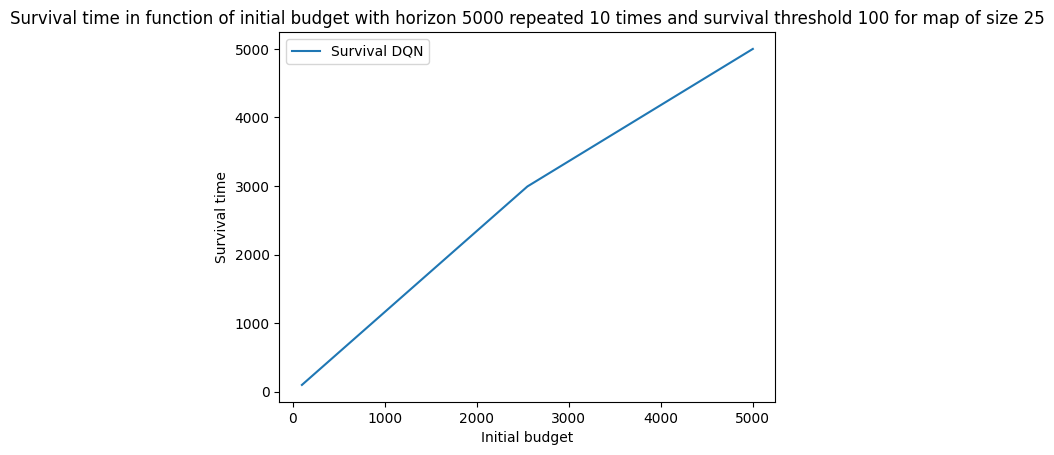

In [12]:
#plt.plot(budgets, cde_time_mean, label="CDELearning")
# plt.plot(initial_budgets, dqn_time_mean, label="Classic DQN")
plt.plot(initial_budgets, survival_dqn_time_mean, label="Survival DQN")
plt.xlabel("Initial budget")
plt.ylabel("Survival time")
plt.legend()
plt.title(f"Survival time in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()

### Alive rate

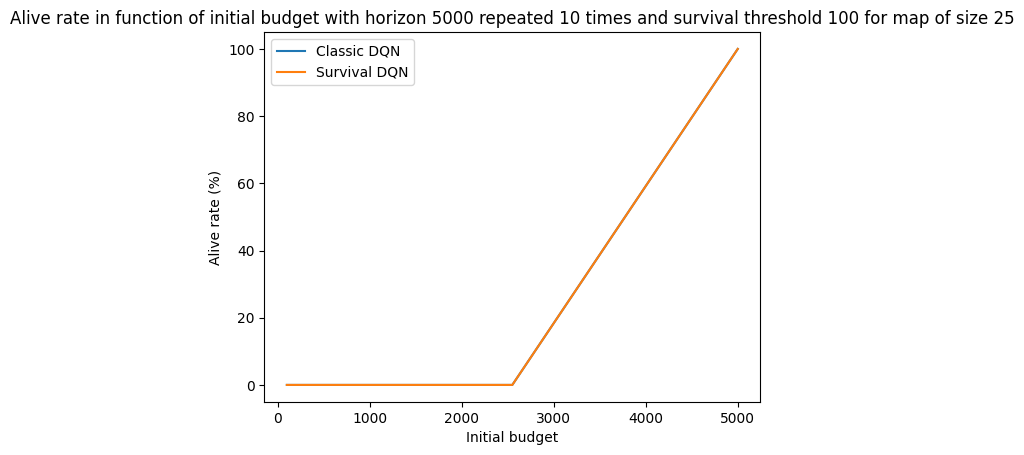

In [8]:
#plt.plot(budgets, cde_alive_rate, label="CDELearning")
plt.plot(initial_budgets, dqn_alive_rate, label="Classic DQN")
plt.plot(initial_budgets, survival_dqn_alive_rate, label="Survival DQN")
plt.xlabel("Initial budget")
plt.ylabel("Alive rate (%)")
plt.legend()
plt.title(f"Alive rate in function of initial budget with horizon {horizon} repeated {repeat} times and survival threshold {survival_threshold} for map of size {map_size}")
plt.show()